In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random

# Load Dataset

(6000, 90, 90, 1) (6000, 4)


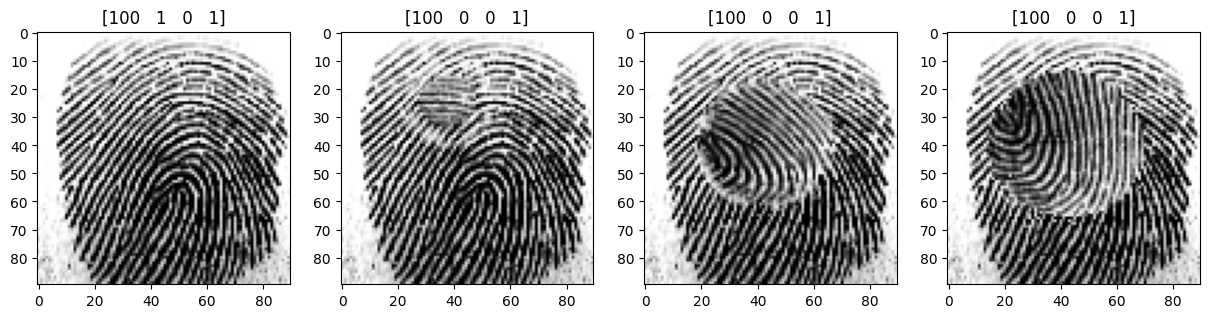

In [2]:
x_real = np.load('processed_dataset/x_real.npz')['data']
y_real = np.load('processed_dataset/y_real.npy')
x_easy = np.load('processed_dataset/x_easy.npz')['data']
y_easy = np.load('processed_dataset/y_easy.npy')
x_medium = np.load('processed_dataset/x_medium.npz')['data']
y_medium = np.load('processed_dataset/y_medium.npy')
x_hard = np.load('processed_dataset/x_hard.npz')['data']
y_hard = np.load('processed_dataset/y_hard.npy')

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')

# Train Test Split

In [3]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(49270, 90, 90, 1) (49270, 4)
(44343, 90, 90, 1) (44343, 4)
(4927, 90, 90, 1) (4927, 4)


# Preview Augmentation

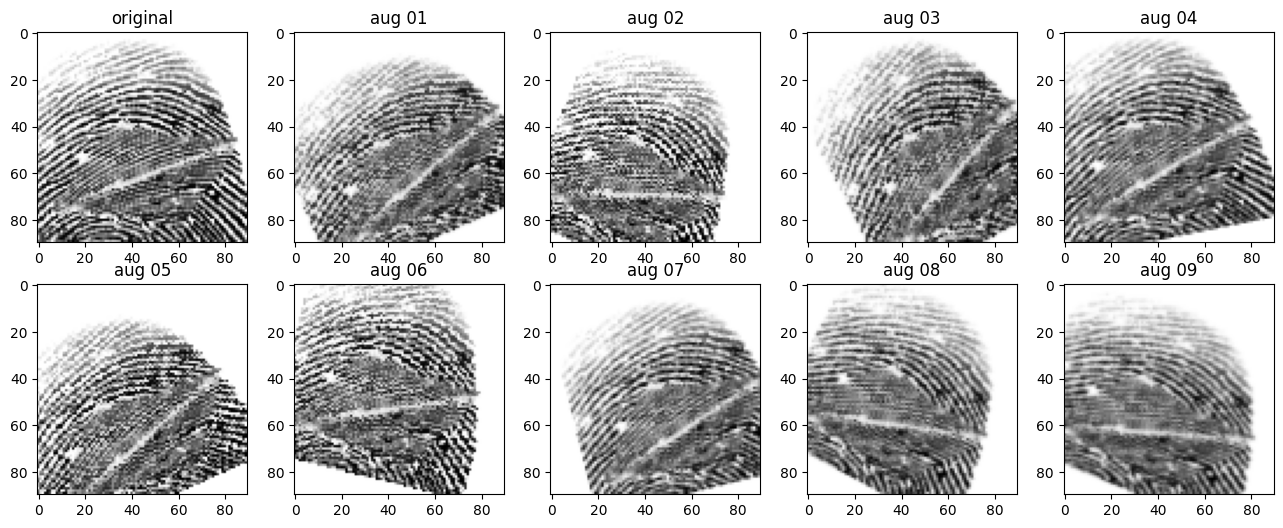

In [4]:
augs = [x_data[40000]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
plt.imshow(x_data[40000].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

# Make Label Dictionary Lookup Table

In [5]:
# ✅ Build label lookup table with correct formatting
label_real_dict = {}

for i, y in enumerate(y_real):
    # Case: label is an array like [1, 6, 0, 0, 1, 0]
    if isinstance(y, np.ndarray):
        key = ''.join([str(int(d)) for d in y]).zfill(6)
    else:  # Case: single number like 160010
        key = str(int(y)).zfill(6)

    label_real_dict[key] = i


# Data Generator

In [6]:
from keras.utils import Sequence
import numpy as np
import random
from sklearn.utils import shuffle
from imgaug import augmenters as iaa

class DataGenerator(Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]

        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)

        # Augmentation on x1_batch
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)
            x1_batch = seq.augment_images(x1_batch)

        # Build pairs (match or unmatch)
        for i, l in enumerate(label_batch):
            # Create formatted match_key
            if isinstance(l, np.ndarray):
                match_key = ''.join([str(int(d)) for d in l]).zfill(6)
            else:
                match_key = str(int(l)).zfill(6)

            # Match: if key exists and random says use match
            if match_key in self.label_real_dict and random.random() > 0.5:
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # Otherwise fallback to unmatched
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))
                    if unmatch_key != match_key:
                        break
                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        # ✅ Return inputs as tuple, not list — this avoids TypeError in fit()
        return (
            x1_batch.astype(np.float32) / 255., 
            x2_batch.astype(np.float32) / 255.
        ), y_batch

    def on_epoch_end(self):
        if self.shuffle:
            self.x, self.label = shuffle(self.x, self.label)


#full code

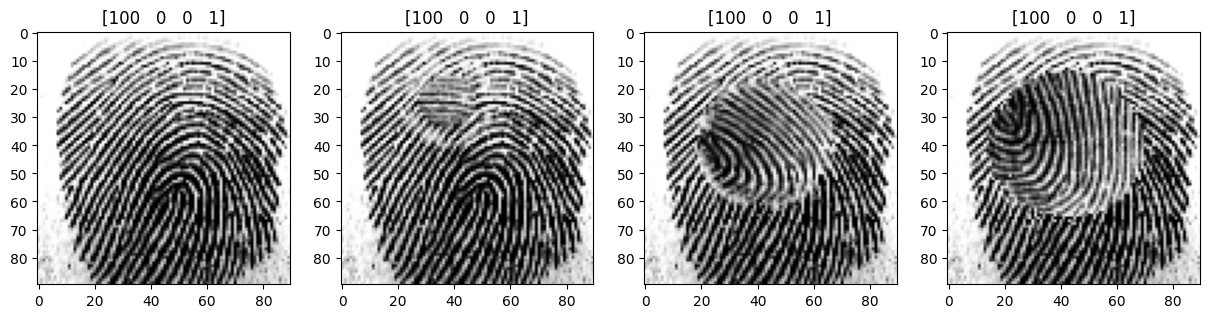

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 90, 90, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 90, 90, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_8        │ (None, 22, 22,    │      9,568 │ input_layer_12[0… │
│ (Functional)        │ 32)               │            │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_4          │ (None, 22, 22,    │          0 │ functional_8[0][… │
│ (Subtract)          │ 32)               │            │ functional_8[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 22, 22,    │      9,248 │ subtract_4[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 11, 11,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 3872)      │          0 │ max_pooling2d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │    247,872 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 266,753 (1.02 MB)

 Trainable params: 266,753 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 123s 88ms/step - accuracy: 0.7891 - loss: 0.4141 - val_accuracy: 0.8403 - val_loss: 0.3529
Epoch 2/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 122s 88ms/step - accuracy: 0.9128 - loss: 0.2153 - val_accuracy: 0.9355 - val_loss: 0.1769
Epoch 3/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 122s 88ms/step - accuracy: 0.9261 - loss: 0.1811 - val_accuracy: 0.9444 - val_loss: 0.1500
Epoch 4/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 122s 88ms/step - accuracy: 0.9381 - loss: 0.1553 - val_accuracy: 0.9468 - val_loss: 0.1429
Epoch 5/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 122s 88ms/step - accuracy: 0.9444 - loss: 0.1416 - val_accuracy: 0.9574 - val_loss: 0.1179
Epoch 6/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 122s 88ms/step - accuracy: 0.9508 - loss: 0.1262 - val_accuracy: 0.9523 - val_loss: 0.1290
Epoch 7/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 122s 88ms/step - accuracy: 0.9575 - loss: 0.1141 - val_accuracy: 0.9647 - val_loss: 0.1014
Epoch 8/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 122s 88ms/step - accuracy: 

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import random

# Load datasets
x_real = np.load('dataset/x_real.npz')['data']
y_real = np.load('dataset/y_real.npy')
x_easy = np.load('dataset/x_easy.npz')['data']
y_easy = np.load('dataset/y_easy.npy')
x_medium = np.load('dataset/x_medium.npz')['data']
y_medium = np.load('dataset/y_medium.npy')
x_hard = np.load('dataset/x_hard.npz')['data']
y_hard = np.load('dataset/y_hard.npy')

# Visualize samples
plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')
plt.show()

# Combine synthetic datasets
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
y_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

# Label to string key
def label_to_str(label):
    return ''.join(map(str, label)).zfill(6)

y_keys = [label_to_str(label) for label in y_data]
unique_keys = np.unique(y_keys)

# Split by identity
train_keys, val_keys = train_test_split(unique_keys, test_size=0.1, random_state=42)
train_mask = np.isin(y_keys, train_keys)
val_mask = np.isin(y_keys, val_keys)

x_train = x_data[train_mask]
y_train = y_data[train_mask]
x_val = x_data[val_mask]
y_val = y_data[val_mask]

assert set([label_to_str(y) for y in y_train]).isdisjoint(set([label_to_str(y) for y in y_val]))

# Real dataset mapping
y_real_dict = {label_to_str(label): idx for idx, label in enumerate(y_real)}

# Data Generator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, y, x_real, y_real_dict, batch_size=32, shuffle=True):
        self.x = x
        self.y = y
        self.x_real = x_real
        self.y_real_dict = y_real_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        x1 = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        y1 = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        x2 = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_out = np.zeros((self.batch_size, 1), dtype=np.float32)

        if self.shuffle:
            aug = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(scale=(0.9, 1.1), rotate=(-25, 25), translate_percent=(-0.1, 0.1), cval=255)
            ])
            x1 = aug.augment_images(x1)

        match_count = 0
        for i, label in enumerate(y1):
            key = label_to_str(label)
            if key in self.y_real_dict and match_count < self.batch_size // 2:
                x2[i] = self.x_real[self.y_real_dict[key]]
                y_out[i] = 1.
                match_count += 1
            else:
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.y_real_dict.items()))
                    if unmatch_key != key:
                        break
                x2[i] = self.x_real[unmatch_idx]
                y_out[i] = 0.

        if self.shuffle:
            x2 = aug.augment_images(x2)

        return (x1.astype(np.float32) / 255., x2.astype(np.float32) / 255.), y_out

    def on_epoch_end(self):
        if self.shuffle:
            self.x, self.y = shuffle(self.x, self.y)

# Siamese Network
def build_siamese():
    def feature_branch():
        inp = layers.Input((90, 90, 1))
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.1)(x)
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.1)(x)
        return Model(inp, x)

    input1 = layers.Input((90, 90, 1))
    input2 = layers.Input((90, 90, 1))
    feat_model = feature_branch()

    f1 = feat_model(input1)
    f2 = feat_model(input2)

    net = layers.Subtract()([f1, f2])
    net = layers.Conv2D(32, 3, padding='same', activation='relu')(net)
    net = layers.MaxPooling2D()(net)
    net = layers.Flatten()(net)
    net = layers.Dense(64, activation='relu')(net)
    net = layers.Dense(1, activation='sigmoid')(net)

    model = Model(inputs=[input1, input2], outputs=net)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train
train_gen = DataGenerator(x_train, y_train, x_real, y_real_dict)
val_gen = DataGenerator(x_val, y_val, x_real, y_real_dict, shuffle=False)

model = build_siamese()
model.summary()

history = model.fit(train_gen, validation_data=val_gen, epochs=15)

# You can now add evaluation metrics or plotting as needed


In [17]:
y_true = []
y_pred = []
y_prob = []

for i in range(len(val_gen)):
    (x1, x2), y = val_gen[i]
    preds = model.predict([x1, x2], verbose=0)
    y_true.extend(y.ravel())
    y_prob.extend(preds.ravel())
    y_pred.extend((preds > 0.5).astype(int).ravel())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")


Accuracy:  0.9724
Precision: 0.9953
Recall:    0.9493
F1 Score:  0.9717
AUC:       0.9988


In [ ]:
import gradio as gr
import cv2
import numpy as np
from keras.models import load_model

# Load trained model (if not in memory already)
# model = load_model("your_model.h5")  # skip if already trained in current session

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (90, 90))
    img = img.astype(np.float32) / 255.
    img = np.expand_dims(img, axis=-1)  # (90, 90, 1)
    return img

def predict_match(img1, img2):
    try:
        img1 = preprocess_image(img1)
        img2 = preprocess_image(img2)

        img1 = np.expand_dims(img1, axis=0)
        img2 = np.expand_dims(img2, axis=0)

        prob = model.predict([img1, img2])[0][0]
        return f"Match probability: {prob:.4f}"
    except Exception as e:
        return f"Error: {e}"

iface = gr.Interface(
    fn=predict_match,
    inputs=[
        gr.Image(label="Fingerprint 1", image_mode='RGB'),
        gr.Image(label="Fingerprint 2", image_mode='RGB')
    ],
    outputs="text",
    title="Fingerprint Match Checker",
    description="Upload two fingerprint images to check similarity."
)

iface.launch()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [ ]:
import gradio as gr
import cv2
import numpy as np

# Optional: Load a separate classifier for fingerprint shape
# classifier = load_model("fingerprint_shape_classifier.h5")

# Map label index to shape name
label_map = {
    0: "Arch",
    1: "Left Loop",
    2: "Right Loop",
    3: "Whorl"
}

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (90, 90))
    img = img.astype(np.float32) / 255.
    img = np.expand_dims(img, axis=-1)
    return img

def predict_shape(img):
    # Dummy logic — replace with actual classification if available
    # pred = classifier.predict(np.expand_dims(img, axis=0))
    # label = np.argmax(pred)
    label = np.random.choice(list(label_map.keys()))  # Replace this with real prediction
    return label_map[label]

def predict_match(img1, img2):
    try:
        proc1 = preprocess_image(img1)
        proc2 = preprocess_image(img2)

        input1 = np.expand_dims(proc1, axis=0)
        input2 = np.expand_dims(proc2, axis=0)

        prob = model.predict([input1, input2])[0][0]

        shape1 = predict_shape(proc1)
        shape2 = predict_shape(proc2)

        result = (
            f"Fingerprint 1: {shape1}\n"
            f"Fingerprint 2: {shape2}\n"
            f"Match probability: {prob:.4f}"
        )
        return result
    except Exception as e:
        return f"Error: {e}"

iface = gr.Interface(
    fn=predict_match,
    inputs=[
        gr.Image(label="Fingerprint 1", image_mode='RGB'),
        gr.Image(label="Fingerprint 2", image_mode='RGB')
    ],
    outputs="text",
    title="Fingerprint Match + Shape Detection",
    description="Upload two fingerprints to see their shapes and match probability."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


# fingerprint → person ID classifier

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# 1. Load your real fingerprint data (already labeled)
x_real = np.load("processed_dataset/x_real.npz")["data"]  # shape: (n_samples, 90, 90, 1)
y_real = np.load("processed_dataset/y_real.npy")          # shape: (n_samples, 6) = person ID (one-hot or array)

# 2. Convert labels to a single integer ID
def label_to_id(label):
    return int("".join(map(str, label)))

y_real_ids = np.array([label_to_id(l) for l in y_real])

# 3. Extract embeddings using the Siamese encoder
embeddings = feature_model.predict(x_real)  # shape: (n_samples, h, w, c)
embeddings_flat = embeddings.reshape(len(embeddings), -1)  # flatten to (n_samples, features)

# 4. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(embeddings_flat, y_real_ids, test_size=0.2, random_state=42)

# 5. Train a classifier on embeddings
clf = RandomForestClassifier(n_estimators=100, random_state=42)
# Or try: clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

# 6. Evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [ ]:
def predict_identity(img):
    # preprocess image: grayscale, resize, normalize
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (90, 90))
    img = img.astype(np.float32) / 255.
    img = np.expand_dims(img, axis=(0, -1))  # shape: (1, 90, 90, 1)

    emb = feature_model.predict(img).reshape(1, -1)
    pred_id = clf.predict(emb)[0]
    return pred_id
